In [1]:
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
import os
import tqdm
import scipy.optimize
import healpy as hp
# sys.path.append('/home/zhuoqizhang/miniconda3/envs/shearDM/lib/python3.10/site-packages/')
import pymaster as nmt

In [2]:
 with h5py.File('/project2/chihway/data/decade/metacal_test_20230328.hdf', 'r') as cat: 
    length = len(cat['ra'])
    print(length)
patchsize = 1000000
n_iter = int(np.ceil(length/patchsize))
print(n_iter)

107820171
108


In [3]:
# computed before
R11, R22 = 0.7358509828007623, 0.7369249358421287

In [4]:
def get_data(i, R11=0.7358509828007623, R22=0.7369249358421287, patchsize=1000000):
    million = patchsize
    with h5py.File('/project2/chihway/data/decade/metacal_test_20230328.hdf', 'r') as cat: 
        mcal_T_noshear = np.array(cat['mcal_T_noshear'][i*million:(i+1)*million])
        mcal_T_ratio_noshear = np.array(cat['mcal_T_ratio_noshear'][i*million:(i+1)*million])
        mcal_s2n_noshear = np.array(cat['mcal_s2n_noshear'][i*million:(i+1)*million])
        mcal_g_noshear = np.array(cat['mcal_g_noshear'][i*million:(i+1)*million])

        mask0 = (~((mcal_T_noshear>2)*(mcal_s2n_noshear<30)))*(mcal_T_noshear<10)*(mcal_s2n_noshear<1000)*(mcal_s2n_noshear>10)*(mcal_T_ratio_noshear>0.5)
        e1 = np.array(cat['mcal_g_noshear'][i*million:(i+1)*million,0][mask0])/R11
        e2 = np.array(cat['mcal_g_noshear'][i*million:(i+1)*million,1][mask0])/R22
        ra = np.array(cat['ra'][i*million:(i+1)*million][mask0])
        dec = np.array(cat['dec'][i*million:(i+1)*million][mask0])
    return e1, e2, ra, dec

In [5]:
def rotate_ellipticities(e1, e2, rot_angle):
        """
        Random rotate ellipticities e1 and e2 over
        angles given in `rot_angle`, which is in
        units of radians
        """

        #Rotate galaxy shapes randomly
        cos = np.cos(rot_angle)
        sin = np.sin(rot_angle)

        e1 = + e1 * cos + e2 * sin
        e2 = - e1 * sin + e2 * cos

        return e1, e2

In [6]:
nside = 1024 # 3 arcmin pixels
npix = hp.nside2npix(nside)

In [6]:
map_count = np.zeros(npix)
map_e1 = np.zeros(npix)
map_e2 = np.zeros(npix)

for i in tqdm.trange(0,n_iter):
    e1, e2, ra, dec = get_data(i,R11=R11,R22=R22, patchsize=patchsize)
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    ind, count = np.unique(pix, return_counts=True)
    map_count[ind] += count
    map_e1 += np.bincount(pix,e1,minlength=npix)
    map_e2 += np.bincount(pix,e2,minlength=npix)

100%|█████████████████████████████████████████████████████████████████████████████████| 108/108 [22:17<00:00, 12.38s/it]


In [26]:
map_e1_mean = map_e1/map_count
map_e1_mean[np.isnan(map_e1_mean)] = 0
map_e2_mean = map_e2/map_count
map_e2_mean[np.isnan(map_e2_mean)] = 0
mask = map_count>0

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
#np.save('/project2/chihway/jackie/decade/Bmode/map_count.npy',map_count)
#np.save('/project2/chihway/jackie/decade/Bmode/map_e1.npy',map_e1_mean)
#np.save('/project2/chihway/jackie/decade/Bmode/map_e2.npy',map_e2_mean)
#mask = map_count>0
#np.save('/project2/chihway/jackie/decade/Bmode/mask.npy',mask)

### generate random realizations

In [11]:
nside = 1024 # 3 arcmin pixels
masklen = np.sum(mask)
rand_map_e1 = np.zeros((2000,masklen))
rand_map_e2 = np.zeros((2000,masklen))

for i in tqdm.trange(0,n_iter):
    e1, e2, ra, dec = get_data(i,R11=R11,R22=R22, patchsize=patchsize)
    pix = hp.ang2pix(nside, ra, dec, lonlat=True)
    for j in range(0,2000): 
        rot_angle = np.random.default_rng(i*2000+j).random(e1.size)*2*np.pi
        e1_rot, e2_rot = rotate_ellipticities(e1, e2, rot_angle)
        rand_map_e1[j] += np.bincount(pix,e1_rot,minlength=npix)[mask]
        rand_map_e2[j] += np.bincount(pix,e2_rot,minlength=npix)[mask]

100%|██████████████████████████████████████████████████████████████████████████████| 108/108 [5:05:45<00:00, 169.86s/it]


In [14]:
rand_map_e1_mean = rand_map_e1.copy()
rand_map_e2_mean = rand_map_e2.copy()
for j in tqdm.trange(0,2000): 
    rand_map_e1_mean[j]/=map_count[mask]
    rand_map_e2_mean[j]/=map_count[mask] 
    np.save(f'/project2/chihway/jackie/decade/Bmode/rand_map_e1_{j}.npy',rand_map_e1_mean[j])
    np.save(f'/project2/chihway/jackie/decade/Bmode/rand_map_e2_{j}.npy',rand_map_e2_mean[j])

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [03:25<00:00,  9.75it/s]


### compute $C_\ell^{BB}$

In [7]:
mask = np.load('/project2/chihway/jackie/decade/Bmode/mask.npy')
map_count = np.load('/project2/chihway/jackie/decade/Bmode/map_count.npy')
map_e1 = np.load('/project2/chihway/jackie/decade/Bmode/map_e1.npy')
map_e2 = np.load('/project2/chihway/jackie/decade/Bmode/map_e2.npy')

In [8]:
edge = (np.linspace(np.sqrt(8), np.sqrt(2048), 33)**2).astype(np.int_)
b = nmt.NmtBin.from_edges(edge[:-1],edge[1:])
ell_eff = b.get_effective_ells()

In [9]:
f2 = nmt.NmtField(mask, [map_e1, -map_e2])

In [10]:
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(f2, f2, b)

In [11]:
cl_coupled = nmt.compute_coupled_cell(f2, f2)
cl_decoupled = w.decouple_cell(cl_coupled)

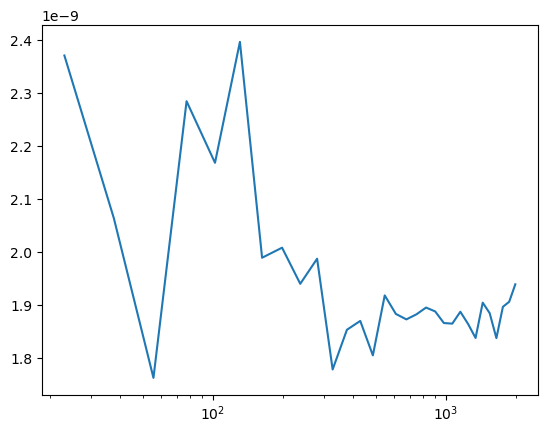

In [12]:
plt.plot(ell_eff[1:], cl_decoupled[3][1:])
plt.xscale('log')

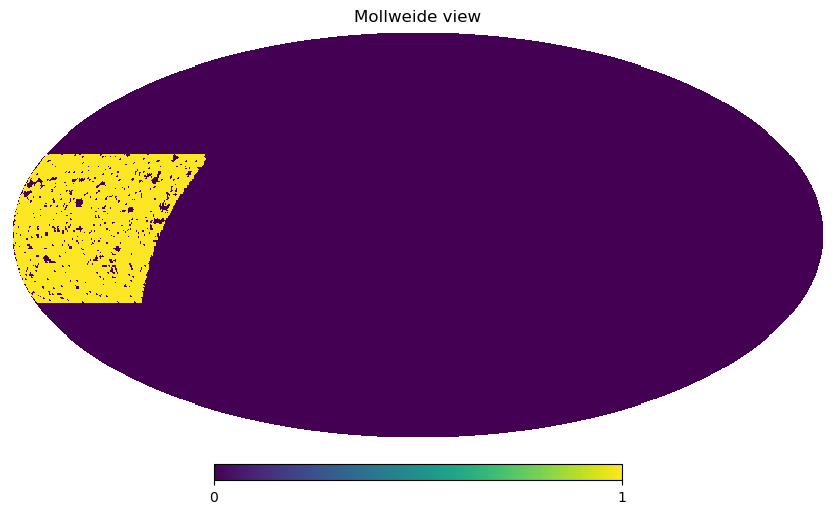

In [45]:
hp.mollview(mask)

In [ ]:
hp.mollview(np.load(''))

### $C_\ell^{BB}$ from random sample

In [31]:
#BB_rand = np.zeros((2000,len(ell_eff)))
BB_rand = np.load('Bmode_rand.npy')
for j in tqdm.trange(100,2000): 
    rand_e1 = np.zeros(npix)
    rand_e2 = np.zeros(npix)
    rand_e1[mask] = np.load(f'/project2/chihway/jackie/decade/Bmode/rand_map_e1_{j}.npy')
    rand_e2[mask] = np.load(f'/project2/chihway/jackie/decade/Bmode/rand_map_e2_{j}.npy')
    frand = nmt.NmtField(mask, [rand_e1, -rand_e2])
    BB_rand[j] = w.decouple_cell(nmt.compute_coupled_cell(frand, frand))[3]
    np.save('Bmode_rand.npy',BB_rand)

100%|█████████████████████████████████████████████████████████████████████████████| 1900/1900 [4:15:35<00:00,  8.07s/it]


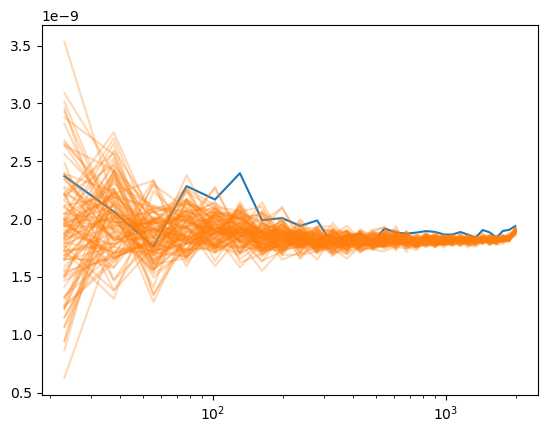

In [13]:
BB_rand = np.load('Bmode_rand.npy')
plt.plot(ell_eff[1:], cl_decoupled[3][1:])
for j in range(100): 
    plt.plot(ell_eff[1:], BB_rand[j][1:],color='tab:orange',alpha=0.3)
plt.xscale('log')

In [25]:
cl_BB = cl_decoupled[3][1:]
cov = np.cov(BB_rand[:,1:].T)
mean = np.mean(BB_rand[:,1:],axis=0)
std = np.sqrt(np.diag(cov))

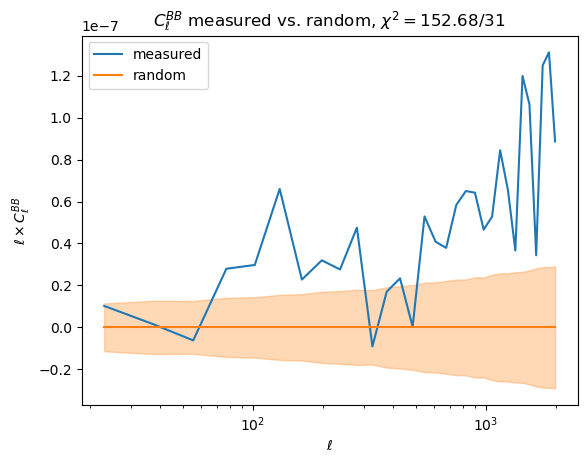

In [44]:
plt.plot(ell_eff[1:],(cl_BB-mean)*ell_eff[1:],label='measured')
plt.plot(ell_eff[1:],0*mean,label='random')
plt.fill_between(ell_eff[1:],0-std*ell_eff[1:],0+std*ell_eff[1:],color='tab:orange',alpha=0.3)
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell\times C_\ell^{BB}$')
plt.title(r'$C_\ell^{BB}$ measured vs. random, $\chi^2=$'+f'{round(np.dot(np.dot(cl_BB-mean,np.linalg.inv(cov)),cl_BB-mean),2)}/31')
plt.legend()

In [32]:
np.dot(np.dot(cl_BB-mean,np.linalg.inv(cov)),cl_BB-mean)

152.67804162923304

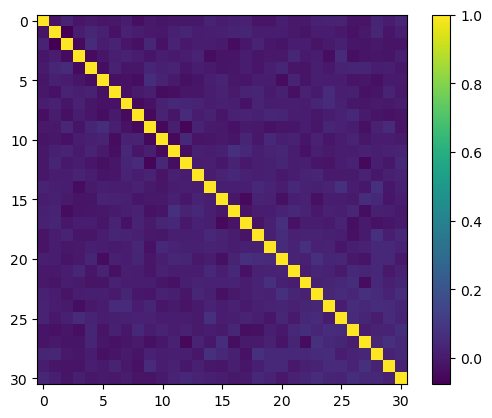

In [39]:
corr = np.copy(cov)
for i in range(len(corr)): 
    for j in range(len(corr)):
        corr[i,j]/=np.sqrt(cov[i,i]*cov[j,j])
plt.imshow(corr)
plt.colorbar()